In [11]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Define a function to interpolate missing time steps in a DataFrame 
def interpolate_missing_time_steps(df):
    time_column = df.columns[0]  # Extract the time column name
    probability_columns = df.columns[1:]  # Extract the names of the probability columns
    df[time_column] = df[time_column].astype(int)  # Convert time values to integers
    full_time_range = range(df[time_column].min(), df[time_column].max() + 1)  # Generate the full range of time steps
    df_reindexed = df.set_index(time_column).reindex(full_time_range).reset_index()  # Reindex the DataFrame to fill missing time steps
    df_reindexed[probability_columns] = df_reindexed[probability_columns].interpolate()  # Interpolate missing probability values
    return df_reindexed  # Return the reindexed DataFrame

def lcr(df, k=1):
    probabilities = df.iloc[:, 1:].values  # Exclude the 'Time' column for calculations
    strengths = np.exp(k * probabilities)

    # Sum strengths per row
    sum_strengths = strengths.sum(axis=1)

    # Compute Luce choice probabilities
    luce_probs = strengths / sum_strengths[:, np.newaxis]
    
    # Step 2: Compute scaling factor Δ_t for each row
    # max(act(t)): maximum activation in the current row
    row_max = df.iloc[:, 1:].max(axis=1)
    # max(act(overall)): global maximum activation across all rows and all items
    global_max = df.iloc[:, 1:].max().max()
    delta = row_max / global_max

    # Step 3: Compute final fixation probabilities p(R_i) = Δ_t * L_i
    # Convert delta to numpy array before reshaping to avoid pandas multi-dimensional indexing error
    fixation_probs = luce_probs * delta.values[:, np.newaxis]

    transformed_df = df.copy()  # Create a copy of the original DataFrame to store results
    transformed_df.iloc[:, 1:] = fixation_probs  # Replace the original probabilities with the fixation probabilities
    return transformed_df

# Define a function to read a CSV file, preprocess data, and apply optional transformations
def read_csv(file_path, shift=False, apply_softmax=False, tmult=1, C=5, k=1, 
             generate_cross=True, apply_lcr_first=False, apply_lcr=False, 
             normalize=False, rescale=False, rescale_first=False, do_interpolate_missing_time_steps=True,
             bgate=False, bthresh=0.01, tmax=1000, sum_weight=1, do_smooth=False):
    df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
    probability_columns = df.columns[1:]  # Extract the names of the probability columns

    if bgate:  # Apply bgate logic if bgate is True
        # print(f'Applying bgate with threshold {threshold}')
        row_sums = df[probability_columns].sum(axis=1)  # Sum probabilities across columns for each row
        mask = row_sums < bthresh  # Identify rows where the sum of probabilities is below the threshold
        df.loc[mask, probability_columns] = 0  # Set probabilities to 0 for those rows
    

    df[probability_columns] = df[probability_columns].clip(lower=0)
        
    if rescale_first:  # Apply rescaling if rescale is True
        print('Rescaling data first')
        df_min = df[probability_columns].min().min()  # Find the minimum value across all columns
        df_max = df[probability_columns].max().max()  # Find the maximum value across all columns
        df[probability_columns] = (df[probability_columns] - df_min) / (df_max - df_min)  # Rescale to [0, 1]

    if apply_lcr_first:  # Apply Luce choice rule if apply_lcr is True
        print(f'Applying lcr FIRST, k = {k}')
        print('BEFORE')
        print(df.tail(5))
        df = lcr(df, k=k)  # Apply LCR to the DataFrame, including only columns in the input
        print(f'AFTER')
        print(df.tail(5))
        print(df.head(5))
        
    if 'Cross' not in df.columns:  # If the 'Cross' column is missing
        sum_columns = ['Target', 'Cohort', 'Rhyme', 'Unrelated']  # Define columns for summation
        sum_columns = [col for col in sum_columns if col in df.columns]  # Filter out columns that are not in the set
        
        if generate_cross:  # If generate_cross is true
            total_sum = df[sum_columns].sum(axis=1)  # Calculate the total sum of probabilities for each row
            trg_max = df['Target'].max()  # Find the maximum value in the 'Target' column
            sum_max = total_sum.max() * sum_weight # Find the maximum value in the 'Target' column
            max_value = 1

            df['Cross'] = max_value - (total_sum / sum_max)  # Scale it to decrease gradually
            df['Cross'] = df['Cross'].clip(lower=0)  # Clip the 'Cross' values to avoid negative values
            # # After generating or computing the 'Cross' column, add this code to ensure 'Cross' stays 0 after hitting zero
            cross_zero_mask = df['Cross'].eq(0)  # Identify where 'Cross' reaches zero
            df['Cross'] = df['Cross'].mask(cross_zero_mask.cumsum().gt(0), 0)  # Set 'Cross' to 0 for the rest of the timesteps
        else:  # If generate_cross is false
            df['Cross'] = np.nan  # Set the 'Cross' column to NaN values

    if rescale:  # Apply rescaling if rescale is True
        print('Rescaling data')
        df_min = df[probability_columns].min().min()  # Find the minimum value across all columns
        df_max = df[probability_columns].max().max()  # Find the maximum value across all columns
        df[probability_columns] = (df[probability_columns] - df_min) / (df_max - df_min)  # Rescale to [0, 1]

    df['Time'] = df['Time'] * tmult  # Multiply the time column by tmult factor
    if do_interpolate_missing_time_steps:  # If interpolation is enabled
        print('Interpolating missing time steps')
        df = interpolate_missing_time_steps(df)  # Interpolate missing time steps
        # input_df = df.copy(deep=True)  # Create a deep copy of the DataFrame

    if apply_lcr:  # Apply Luce choice rule if apply_lcr is True
        print(f'Applying lcr, k={k}')
        df = lcr(df, k=k)  # Apply LCR to the DataFrame, including columns in the input AND cross if it's been added

    if normalize:  # Apply normalization if normalize is True
        row_sums = df[probability_columns].sum(axis=1)  # Get the sum for each row
        non_zero_mask = df[probability_columns] != 0  # Create a mask where the values are non-zero
        df[probability_columns] = df[probability_columns].where(~non_zero_mask, df[probability_columns].div(row_sums, axis=0))  # Normalize only non-zero values
    
    if apply_softmax:  # If softmax is enabled
        df = softmax(df[probability_columns].values, axis=1)  # Apply standard softmax transformation
    
    # Trim the DataFrame to only include rows where 'Time' is less than or equal to tmax
    df = df[df['Time'] <= tmax]

    if do_smooth:  # If smoothing is enabled
        print('Applying smoothing')
        for col in probability_columns:  # Apply smoothing to each probability column
            df[col] = df[col].rolling(window=50, min_periods=1, center=True).mean()  # Apply a rolling mean with a window size of 5
            
    return df  # Return transformed DataFrame

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(human_df, comp_df, modelname):
    """
    Calculates objective metrics (RMSE, MAE, Correlation) to measure the difference 
    between human and simulated fixation proportions.
    """
    item_types = ["Target", "Cohort", "Rhyme", "Unrelated", "Cross"]
    
    # Align dataframes by length
    min_len = min(len(human_df), len(comp_df))
    h_df = human_df.iloc[:min_len].reset_index(drop=True)
    c_df = comp_df.iloc[:min_len].reset_index(drop=True)
    
    metrics = {}
    print(f"\n{'='*20} {modelname} Objective Metrics {'='*20}")
    print(f"{'Item':<12} | {'RMSE':<10} | {'MAE':<10} | {'Correlation':<10}")
    print("-" * 55)
    
    total_sq_error = 0
    total_abs_error = 0
    total_count = 0
    
    for item in item_types:
        if item in h_df.columns and item in c_df.columns:
            y_true = h_df[item]
            y_pred = c_df[item]
            
            # RMSE
            mse = np.mean((y_true - y_pred)**2)
            rmse = np.sqrt(mse)
            
            # MAE
            mae = np.mean(np.abs(y_true - y_pred))
            
            # Correlation
            if y_true.std() == 0 or y_pred.std() == 0:
                corr = 0
            else:
                corr = np.corrcoef(y_true, y_pred)[0, 1]
                
            metrics[item] = {'RMSE': rmse, 'MAE': mae, 'Correlation': corr}
            print(f"{item:<12} | {rmse:.4f}     | {mae:.4f}     | {corr:.4f}")
            
            total_sq_error += np.sum((y_true - y_pred)**2)
            total_abs_error += np.sum(np.abs(y_true - y_pred))
            total_count += len(y_true)
            
    # Global weighted metrics
    if total_count > 0:
        global_rmse = np.sqrt(total_sq_error / total_count)
        global_mae = total_abs_error / total_count
        print("-" * 55)
        print(f"{'Overall':<12} | {global_rmse:.4f}     | {global_mae:.4f}     | {'-':<10}")
        print(f"{'='*60}\n")
        
    return metrics

def plot_fixation_proportions(human_df, comp_df, modelname, symbol_interval=25):
    markers = {"Target": "o", "Cohort": "s", "Rhyme": "^", "Unrelated": ".", "Cross": "x"}  # Define markers for different item types
    item_types = ["Target", "Cohort", "Rhyme", "Unrelated", "Cross"]  # List of item types

    # Define custom font sizes
    title_fontsize = 24
    axis_label_fontsize = 22
    tick_labelsize = 18
    legend_fontsize = 18
    annotate_fontsize = 32
    
    # Ensure both dataframes cover the same time range for comparison
    # We assume 'Time' is available or the index represents time. 
    # Based on read_csv, 'Time' is a column but indices are reset.
    # Let's align them based on the minimum common length to simply truncate the longer one,
    # or better, align by their 'Time' column if possible.
    
    # Assuming standard index alignment (0, 1, 2...) if they start at same relative time:
    min_len = min(len(human_df), len(comp_df))
    human_df_clipped = human_df.iloc[:min_len]
    comp_df_clipped = comp_df.iloc[:min_len]
    
    fig, ax = plt.subplots(figsize=(20, 12))
    for item in item_types:
        if item in human_df_clipped.columns and item in comp_df_clipped.columns:
            difference = human_df_clipped[item] - comp_df_clipped[item]
            # Use the time column if available for x-axis, else use index
            if 'Time' in human_df_clipped.columns:
                x_axis = human_df_clipped['Time']
            else:
                x_axis = human_df_clipped.index
                
            ax.plot(x_axis, difference, label=item, marker=markers.get(item, ''), markevery=symbol_interval)

    ax.set_title('Differences (human - simulated)', fontsize=title_fontsize)
    ax.set_xlabel('Time step', fontsize=axis_label_fontsize)
    ax.set_ylabel('Fixation proportion difference', fontsize=axis_label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_labelsize)  # Set tick label size
    ax.legend(fontsize=legend_fontsize)
    ax.set_ylim(-1, 1)
    fig.suptitle(f'Differences (human - simulated) for {modelname}', fontsize=title_fontsize)
    fig.savefig(f'DIFF/differences_{modelname}.png')
    
    # show human df and comp df  
    fig, axes = plt.subplots(2, 1, figsize=(20, 24))
    axes[0].set_title('Human Data', fontsize=title_fontsize)
    axes[1].set_title('Simulated Data', fontsize=title_fontsize)
    for item in item_types:
        if item in human_df_clipped.columns:
            axes[0].plot(human_df_clipped['Time'], human_df_clipped[item], label=item, marker=markers.get(item, ''), markevery=symbol_interval)
        if item in comp_df_clipped.columns:
            # axes[1].axvline(x=480, color='gray', linestyle='--', alpha=0.5, label="theoratical earliest RT")  # Add vertical line at the start of the time range
            axes[1].plot(comp_df_clipped['Time'], comp_df_clipped[item], label=item, marker=markers.get(item, ''), markevery=symbol_interval)
    for ax in axes:
        ax.set_xlabel('Time step', fontsize=axis_label_fontsize)
        ax.set_ylabel('Fixation proportion', fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_labelsize)  # Set tick label size
        ax.legend(fontsize=legend_fontsize)
    fig.savefig(f'OUT/fixation_proportions_{modelname}.png')


Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps
Interpolating missing time steps


/tmp/ipykernel_2911683/2054622731.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


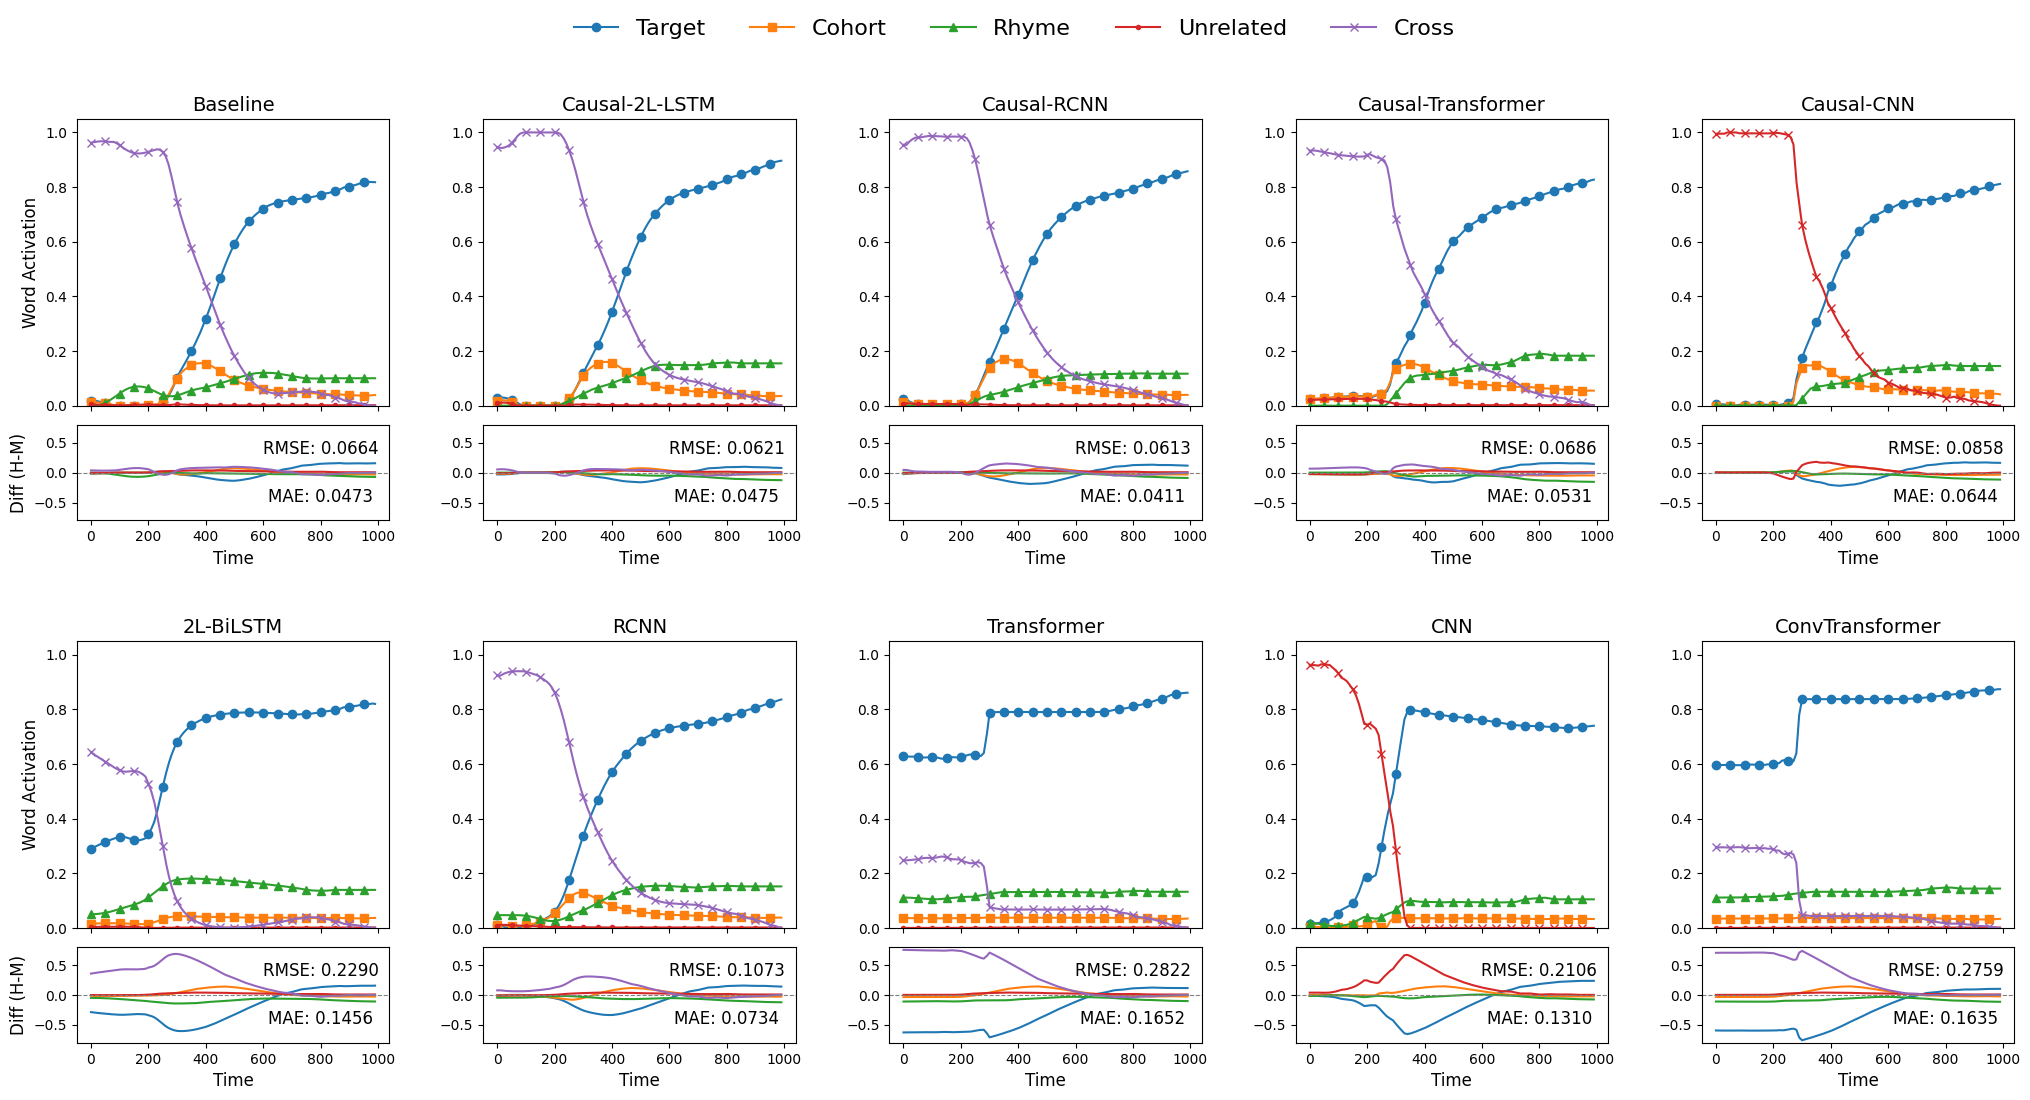

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os,sys
# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and define project root accordingly
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    # Assume we are already at the project root or handle other structures as needed
    project_root = current_dir

if project_root not in sys.path:
    print(f"Adding {project_root} to sys.path")
    sys.path.append(project_root)

model2metrics = {
    "Baseline": {"RMSE": 0.0664, "MAE": 0.0473},
    "Causal-2L-LSTM": {"RMSE": 0.0621, "MAE": 0.0475},
    "Causal-RCNN": {"RMSE": 0.0613, "MAE": 0.0411},
    "Causal-Transformer": {"RMSE": 0.0686, "MAE": 0.0531},
    "Causal-CNN": {"RMSE": 0.0858, "MAE": 0.0644},

    "2L-BiLSTM": {"RMSE": 0.2290, "MAE": 0.1456},
    "RCNN": {"RMSE": 0.1073, "MAE": 0.0734},
    "Transformer": {"RMSE": 0.2822, "MAE": 0.1652},
    "CNN": {"RMSE": 0.2106, "MAE": 0.1310},
    "ConvTransformer": {"RMSE": 0.2759, "MAE": 0.1635},
}

model2res = {
    # ── Causal Models ──────────────────────────────────────────────────────────
    "Baseline":         "experiments/en_words_ku_baseline/Baseline/training/competition_mean.csv",
    "Causal-2L-LSTM":   "experiments/en_words_ku_causal_2lstm/causal-2LSTM/training/competition_mean.csv",
    "Causal-RCNN":      "experiments/en_words_ku_causal_rcnn/causal-rcnn/training/competition_mean.csv",
    "Causal-Transformer":"experiments/en_words_ku_causal_trans/causal-trans/training/competition_mean.csv",
    "Causal-CNN":       "experiments/en_words_ku_causal_cnn/causal-cnn/training/competition_mean.csv",
    # ── Non-Causal Models ──────────────────────────────────────────────────────
    "2L-BiLSTM":        "experiments/en_words_ku_2lstmbi/noncausal-2LSTM/training/competition_mean.csv",
    "RCNN":             "experiments/en_words_ku_rcnn/noncausal-rcnn/training/competition_mean.csv",
    "Transformer":      "experiments/en_words_ku_trans/noncausal-trans/training/competition_mean.csv",
    "CNN":              "experiments/en_words_ku_cnn/noncausal-cnn/training/competition_mean.csv",
    "ConvTransformer":  "experiments/en_words_ku_convtrans/noncausal-convtrans/training/competition_mean.csv",
}

# Parameters
item_types = ["Target", "Cohort", "Rhyme", "Unrelated", "Cross"]
markers = {"Target": "o", "Cohort": "s", "Rhyme": "^", "Unrelated": ".", "Cross": "x"}
symbol_interval = 50

# Setup Figure
cols = 5
rows = 2
fig = plt.figure(figsize=(25, 12))

# Use nested gridspecs to control spacing
# Outer grid for the 2x5 layout of model groups
# hspace=0.3 separates the two rows of models nicely
outer_gs = gridspec.GridSpec(2, 5, figure=fig, hspace=0.3, wspace=0.3)

human_df = read_csv(os.path.join(project_root, "notebooks/INPUT/amt_lcr_from_paper.csv"), normalize=False, rescale=False, tmult=1, 
                    apply_lcr_first=False, apply_lcr=False, k=1, bgate=False, bthresh=0.01, tmax=1000)

# model2res has exactly 10 entries (5 causal + 5 non-causal), filling the 2×5 grid exactly
plot_items = list(model2res.items())

handles = []
labels = []
legend_captured = False

for i, (modelname, csv_path) in enumerate(plot_items):
    row_group = i // cols
    col = i % cols
    
    # Create an inner grid for each model cell: 2 rows (Sim, Diff)
    # Reduced hspace to 0.1 to bring Sim and Diff plots closer together
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[row_group, col], 
                                                height_ratios=[3, 1], hspace=0.1)
    
    # Share x-axis to align time steps
    ax_sim = fig.add_subplot(inner_gs[0])
    ax_diff = fig.add_subplot(inner_gs[1], sharex=ax_sim)
    
    # Load Model Data
    comp_df = read_csv(os.path.join(project_root, csv_path), normalize=False, rescale=False, tmult=10, 
                    apply_lcr_first=False, apply_lcr=False, k=1, bgate=False, bthresh=0.00, tmax=1000)

    if modelname == "2LSTM":
        # show the cross item for 2LSTM to illustrate the difference
        print(f"2LSTM Cross values:\n{comp_df['Cross'].head(10)}")
        
    # Align Data
    min_len = min(len(human_df), len(comp_df))
    h_clipped = human_df.iloc[:min_len]
    c_clipped = comp_df.iloc[:min_len]
    x_axis = h_clipped['Time']

    # 1. Plot Simulation (Phonological Competition)
    for item in item_types:
        if item in c_clipped.columns:
            line, = ax_sim.plot(x_axis, c_clipped[item], label=item, 
                                marker=markers.get(item, ''), markevery=symbol_interval)
            if not legend_captured:
                handles.append(line)
                labels.append(item)
    
    ax_sim.set_title(modelname, fontsize=14)
    ax_sim.set_ylim(0, 1.05)
    
    # Hide x-axis labels for the top subplot (sim) to reduce clutter since they share x-axis
    plt.setp(ax_sim.get_xticklabels(), visible=False)
    
    if col == 0:
        ax_sim.set_ylabel("Word Activation", fontsize=12)

    # 2. Plot Diff (Human - Model)
    for item in item_types:
        if item in h_clipped.columns and item in c_clipped.columns:
            diff = h_clipped[item] - c_clipped[item]
            ax_diff.plot(x_axis, diff, label=item)
            
    # Add Metrics Text
    if modelname in model2metrics:
        m = model2metrics[modelname]
        rmse = m.get('RMSE')
        mae = m.get('MAE')
        if rmse is not None:
             ax_diff.text(800, 0.4, f"RMSE: {rmse:.4f}", fontsize=12, ha='center', va='center')
        if mae is not None:
             ax_diff.text(800, -0.4, f"MAE: {mae:.4f}", fontsize=12, ha='center', va='center')

    ax_diff.set_ylim(-0.8, 0.8)
    ax_diff.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    if col == 0:
        ax_diff.set_ylabel("Diff (H-M)", fontsize=12)
    ax_diff.set_xlabel("Time", fontsize=12)

    legend_captured = True # Only capture legend once

# Global Legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(item_types), fontsize=16, frameon=False)

# Adjust layout carefully
# We rely on gridspec for internal spacing, but tight_layout helps with outer margins
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('OUT/all_models_comparison.png')
plt.show()


In [14]:

# Calculate average RMSE and MAE for causal vs non-causal models
causal_rmse = []
causal_mae = []
noncausal_rmse = []
noncausal_mae = []

for model, metrics in model2metrics.items():
    if model.startswith("causal-"):
        causal_rmse.append(metrics["RMSE"])
        causal_mae.append(metrics["MAE"])
    else:
        noncausal_rmse.append(metrics["RMSE"])
        noncausal_mae.append(metrics["MAE"])

# Calculate averages
avg_causal_rmse = sum(causal_rmse) / len(causal_rmse) if causal_rmse else 0
avg_causal_mae = sum(causal_mae) / len(causal_mae) if causal_mae else 0

avg_noncausal_rmse = sum(noncausal_rmse) / len(noncausal_rmse) if noncausal_rmse else 0
avg_noncausal_mae = sum(noncausal_mae) / len(noncausal_mae) if noncausal_mae else 0

print(f"Causal Models - Avg RMSE: {avg_causal_rmse:.4f}, Avg MAE: {avg_causal_mae:.4f}")
print(f"Non-Causal Models - Avg RMSE: {avg_noncausal_rmse:.4f}, Avg MAE: {avg_noncausal_mae:.4f}")


Causal Models - Avg RMSE: 0.0000, Avg MAE: 0.0000
Non-Causal Models - Avg RMSE: 0.1449, Avg MAE: 0.0932


Interpolating missing time steps
Applying lcr FIRST, k = 6
BEFORE
    Time  Target  Cohort  Rhyme
45   900  0.1483  0.0004    0.0
46   920  0.1433  0.0005    0.0
47   940  0.1408  0.0005    0.0
48   960  0.1307  0.0006    0.0
49   980  0.1374  0.0005    0.0
AFTER
    Time    Target    Cohort     Rhyme
45   900  0.548708  0.225917  0.225375
46   920  0.522948  0.222001  0.221336
47   940  0.510286  0.219900  0.219241
48   960  0.460313  0.210883  0.210126
49   980  0.493262  0.216944  0.216294
   Time  Target  Cohort  Rhyme
0     0     0.0     0.0    0.0
1    20     0.0     0.0    0.0
2    40     0.0     0.0    0.0
3    60     0.0     0.0    0.0
4    80     0.0     0.0    0.0
Rescaling data
Interpolating missing time steps
Applying smoothing
Applying lcr FIRST, k = 6
BEFORE
    Time  Target  Cohort  Rhyme
45   900  0.1480  0.0002    0.0
46   920  0.1537  0.0003    0.0
47   940  0.1570  0.0004    0.0
48   960  0.1493  0.0004    0.0
49   980  0.1499  0.0005    0.0
AFTER
    Time    Target

/tmp/ipykernel_2911683/2850893730.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.85])


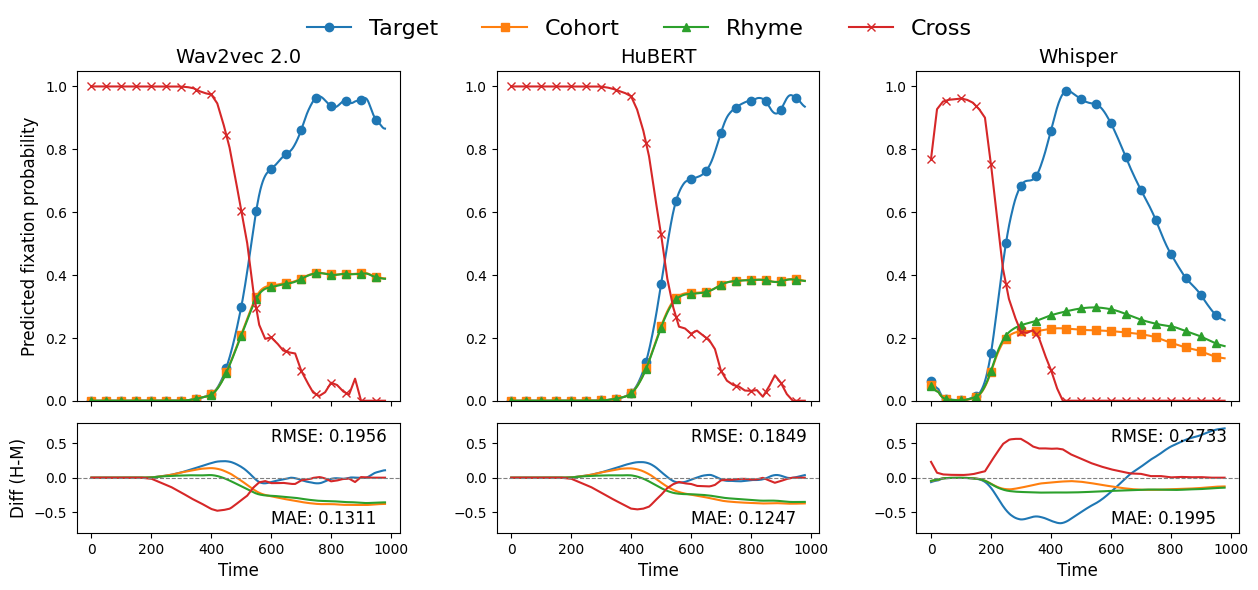

In [15]:
# Academic-style comparison of pretrained speech models vs. human data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

model2res = {
    "Wav2vec 2.0": "/home/fie24002/earshot_nn/experiments/wav2vec2/competition_mean.csv",
    "HuBERT": "/home/fie24002/earshot_nn/experiments/hubert/facebook/hubert-large-ls960-ft/competition_mean.csv",
    "Whisper": "/home/fie24002/earshot_nn/experiments/whisper_realtime/competition_mean.csv",
}

# Parameters
item_types = ["Target", "Cohort", "Rhyme", "Unrelated", "Cross"]
markers = {"Target": "o", "Cohort": "s", "Rhyme": "^", "Unrelated": ".", "Cross": "x"}
symbol_interval = 50

# Setup Figure
num_models = len(model2res)
cols = 3 # We want 1 row of 3 models
rows = 1
fig = plt.figure(figsize=(15, 6)) # Adjusted width for 3 cols

# Use nested gridspecs to control spacing
# Outer grid for the 1x3 layout of model groups
outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.3)

human_df = read_csv(os.path.join(project_root, "notebooks/INPUT/amt_lcr_from_paper.csv"), normalize=False, rescale=False, tmult=1, do_interpolate_missing_time_steps=True,
                    apply_lcr_first=False, apply_lcr=False, k=1, bgate=False, bthresh=0.01, tmax=1000)

plot_items = list(model2res.items())
# No "Human Data" appended here as we have 3 models filling 3 slots exactly

handles = []
labels = []
legend_captured = False

for i, (modelname, csv_path) in enumerate(plot_items):
    col = i # Simple column index since rows=1
    
    # Create an inner grid for each model cell: 2 rows (Sim, Diff)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0, col], 
                                                height_ratios=[3, 1], hspace=0.1)
    
    # Share x-axis to align time steps
    ax_sim = fig.add_subplot(inner_gs[0])
    ax_diff = fig.add_subplot(inner_gs[1], sharex=ax_sim)
    
    # Load Model Data
    comp_df = read_csv(os.path.join(project_root, csv_path), normalize=False, rescale=True, tmult=1, do_interpolate_missing_time_steps=True,
                    apply_lcr_first=True, apply_lcr=False, k=6, bgate=False, bthresh=0.01, tmax=1000, do_smooth=True)

    # Align Data
    min_len = min(len(human_df), len(comp_df))
    h_clipped = human_df.iloc[:min_len]
    c_clipped = comp_df.iloc[:min_len]
    x_axis = h_clipped['Time']

    # 1. Plot Simulation (Phonological Competition)
    for item in item_types:
        if item in c_clipped.columns:
            line, = ax_sim.plot(x_axis, c_clipped[item], label=item, 
                                marker=markers.get(item, ''), markevery=symbol_interval)
            if not legend_captured:
                handles.append(line)
                labels.append(item)
    
    ax_sim.set_title(modelname, fontsize=14)
    ax_sim.set_ylim(0, 1.05)
    plt.setp(ax_sim.get_xticklabels(), visible=False)
    
    if col == 0:
        ax_sim.set_ylabel("Predicted fixation probability", fontsize=12)

    # 2. Plot Diff (Human - Model)
    # Calculate difference
    diff_data = pd.DataFrame({'Time': x_axis})
    total_sq_error = 0
    total_abs_error = 0
    total_count = 0
    
    for item in item_types:
        if item in h_clipped.columns and item in c_clipped.columns:
            diff = h_clipped[item] - c_clipped[item]
            diff_data[item] = diff
            ax_diff.plot(x_axis, diff, label=item)
            
            # Aggregate errors for RMSE/MAE calculation
            y_true = h_clipped[item]
            y_pred = c_clipped[item]
            total_sq_error += np.sum((y_true - y_pred)**2)
            total_abs_error += np.sum(np.abs(y_true - y_pred))
            total_count += len(y_true)
            
    # Calculate Global Metrics for this model
    if total_count > 0:
        rmse = np.sqrt(total_sq_error / total_count)
        mae = total_abs_error / total_count
        
        # Display Metrics on Plot
        ax_diff.text(600, 0.6, f"RMSE: {rmse:.4f}", fontsize=12, ha='left', va='center')
        ax_diff.text(600, -0.6, f"MAE: {mae:.4f}", fontsize=12, ha='left', va='center')

    ax_diff.set_ylim(-0.8, 0.8)
    ax_diff.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    if col == 0:
        ax_diff.set_ylabel("Diff (H-M)", fontsize=12)
    ax_diff.set_xlabel("Time", fontsize=12)

    legend_captured = True

# Global Legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(item_types), fontsize=16, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.savefig('OUT/all_models_comparison_3models.png')
plt.show()